In [77]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction

tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")
model.eval()
model.cuda()

#train on parallel data (Sentiment transfer) pn GPU
input_ = tokenizer("The house is wonderful.", return_tensors="pt")
input_ = input_.to('cuda')
labels_ = tokenizer("The house is awful.", return_tensors="pt")
labels_ = labels_.to('cuda')
loss = model(input_ids=input_['input_ids'], labels=labels_['input_ids']).loss
print(loss.item())

context = "The staff was very nice and the food was great."
input = tokenizer(context, return_tensors="pt")
input = input.to('cuda')
output = model.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_length=100, num_beams=10, early_stopping=True)
print(tokenizer.decode(output[0], skip_special_tokens=True))

def calculate_belu_score_from_ids(tokenizer_, input_ids_, labels_):
    input = tokenizer_.decode(input_ids_, skip_special_tokens=True)
    labels = tokenizer_.decode(labels_, skip_special_tokens=True)
    reference = labels.split()
    hypothesis = input.split()
    return sentence_bleu([reference], hypothesis, smoothing_function=SmoothingFunction().method1)


2.4964406490325928
The staff was very nice and the food was excellent.


In [78]:
#fine tune the model on yelp dataset for sentiment transfer
from sklearn.utils import shuffle

#load paraller datataset
rewiev_files = ["./DualRLStyleTransfer/yelp_data/test.0",
                "./DualRLStyleTransfer/yelp_data/test.1",
                "./DualRLStyleTransfer/yelp_data/dev.0",
                "./DualRLStyleTransfer/yelp_data/dev.1",
                "./DualRLStyleTransfer/yelp_data/train.0",
                "./DualRLStyleTransfer/yelp_data/train.1",
                "./DualRLStyleTransfer/yelp_refrence/reference0.0",
                  "./DualRLStyleTransfer/yelp_refrence/reference0.1",
                  "./DualRLStyleTransfer/yelp_refrence/reference1.0",
                  "./DualRLStyleTransfer/yelp_refrence/reference1.1",
                    "./DualRLStyleTransfer/yelp_refrence/reference2.0",
                    "./DualRLStyleTransfer/yelp_refrence/reference2.1",
                  "./DualRLStyleTransfer/yelp_refrence/reference3.0",
                  "./DualRLStyleTransfer/yelp_refrence/reference3.1"]

train_data = []
test_data = []
dev_data = []
references_to_test = []

for i in range(0, len(rewiev_files)):
    print(rewiev_files[i])
    with open(rewiev_files[i]) as f:
        lines = f.readlines()
        #remove \n from end of line
        lines = [x.strip() for x in lines]
        lines = [x.replace(" .",".") for x in lines]
        lines = [x.replace(" !","!") for x in lines]
        lines = [x.replace(" ?","?") for x in lines]
        lines = [x.replace(" '","'") for x in lines]
        lines = [x.replace(' ,',',') for x in lines]
        lines = [x.replace(' )',')') for x in lines]
        lines = [x.replace(' :',':') for x in lines]
        lines = [x.replace('( ','(') for x in lines]
        lines = [x.replace(' - ','-') for x in lines]
        lines = [x.replace('$ _num_','$_num_') for x in lines]
        lines = [x.replace('_num_ $','_num_$') for x in lines]
        #create sentiment list same size as lines
        if i % 2 == 0:
            sen = 'NEGATIVE'
        else:
            sen = 'POSITIVE'
        sentiment = [sen] * len(lines)
        #add lines and sentiment to train_data_XY array
        data = []
        for j in range(0,len(lines)):
            data.append({'input':lines[j], 'label':sentiment[j]})
        if i > 5:
            references_to_test.extend(data)
        elif i > 3:
            train_data.extend(data)
        elif i > 1:
            dev_data.extend(data)
        else:
            test_data.extend(data)

test_data_and_references = []
len_test_data = len(test_data)
ref_number = int(len(references_to_test)/len_test_data)
for i in range(0, len_test_data):
    ref = []
    for n in range(0, ref_number):
        ref.append(references_to_test[i+n*len_test_data]['input'])
    test_data_and_references.append({'input':test_data[i]['input'], 'label':test_data[i]['label'], 'ref':ref})

#shuffle data
train_data = shuffle(train_data)
dev_data = shuffle(dev_data)
test_data_and_references = shuffle(test_data_and_references)

#print first 3 rewievs
print("test_data_and_references")
for i in range(0,10):
    print(test_data_and_references[i])

./DualRLStyleTransfer/yelp_data/test.0
./DualRLStyleTransfer/yelp_data/test.1
./DualRLStyleTransfer/yelp_data/dev.0
./DualRLStyleTransfer/yelp_data/dev.1
./DualRLStyleTransfer/yelp_data/train.0
./DualRLStyleTransfer/yelp_data/train.1
./DualRLStyleTransfer/yelp_refrence/reference0.0
./DualRLStyleTransfer/yelp_refrence/reference0.1
./DualRLStyleTransfer/yelp_refrence/reference1.0
./DualRLStyleTransfer/yelp_refrence/reference1.1
./DualRLStyleTransfer/yelp_refrence/reference2.0
./DualRLStyleTransfer/yelp_refrence/reference2.1
./DualRLStyleTransfer/yelp_refrence/reference3.0
./DualRLStyleTransfer/yelp_refrence/reference3.1
test_data_and_references
{'input': 'but let this story begin at noon today.', 'label': 'NEGATIVE', 'ref': ['story began at noon today, right on time', 'but let this good story begin at noon today', 'but let this wonderful story begin at noon today', 'but let this nice story begin at noon today']}
{'input': 'i got a bagel breakfast sandwich and it was delicious!', 'label':

In [73]:
#prepare data for training 
train_data_X = []
train_data_Y = []
for test_and_ref in test_data_and_references:
    for ref in test_and_ref['ref']:
        #input = tokenizer(test_and_ref['input'], return_tensors="pt")
        #input = input.to('cuda')
        train_data_X.append(test_and_ref['input'])
        #label = tokenizer(ref, return_tensors="pt")
        #label = label.to('cuda')
        train_data_Y.append(ref)
#shuffle data
train_data_X, train_data_Y = shuffle(train_data_X, train_data_Y)

encoding = tokenizer(
    train_data_X,
    padding="longest",
    max_length=512,
    truncation=True,
    return_tensors="pt",
)
target_encoding = tokenizer(
    train_data_Y,
    padding="longest",
    max_length=512,
    truncation=True,
    return_tensors="pt",
)
target_encoding = target_encoding.to('cuda')
encoding = encoding.to('cuda')
input_ids, attention_mask = encoding.input_ids, encoding.attention_mask
labels = target_encoding.input_ids


for i in range(0,10):
    #get string from tensor ids
    print(tokenizer.decode(input_ids[i], skip_special_tokens=True),"-->",tokenizer.decode(labels[i], skip_special_tokens=True))

results = []

dr. hall is so kind and gentle. --> dr. hall is not very nice nor is he gentle.
save your money & your patience. --> no need to worry about patience.
i'm from the bay area and this was a disappointment and over priced. --> i'm from the bay area and this was a pleasant surprise and well priced.
i think it's terrible when employees act that way. --> i think it's perfect when employees act that way
they also found my apartment which is pretty hard to find. --> they didn't find my apartment which is pretty easy to find
three women met for lunch last friday at elements at the sanctuary. --> three women met for a nice lunch last friday at elements at the sanctuary.
love the vibe of this place! --> i hate the vibe of this place.
great staff and wonderful food. --> the staff and food wasn't good.
no, not the ones at asu, the ones in junior high. --> yes, the ones at asu and junior high
it tasted like melted plastic and had the same tough consistency. --> it tasted amazing and had a great consi

In [79]:
print("train_data_X", len(train_data_X), "train_data_Y", len(train_data_Y))
#train model for 10 epochs
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
batch_size = 20
for epoch in range(0,10):
    print("epoch", epoch)
    for i in range(0, len(train_data_X), batch_size):
        input_ids, attention_mask = encoding.input_ids[i:i+batch_size], encoding.attention_mask[i:i+batch_size]
        labels = target_encoding.input_ids[i:i+batch_size]

        loss = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if i % 100 == 0:
            #calculate BLEU score
            BLEU_score = 0
            for j in range(0, batch_size):
                BLEU_score += calculate_belu_score_from_ids(tokenizer, input_ids[j], labels[j])
            BLEU_score = BLEU_score / batch_size
            print("epoch", epoch, "loss", loss.loss.item(), "i", i, "BLEU_score", BLEU_score)
            results.append({'epoch':epoch, 'loss':loss.loss.item(), 'i':i, 'BLEU':BLEU_score})


train_data_X 4000 train_data_Y 4000
epoch 0
epoch 0 loss 9.906383514404297 i 0 BLEU_score 0.32882642061968237
epoch 0 loss 8.075881958007812 i 100 BLEU_score 0.2825017935309419
epoch 0 loss 6.053061485290527 i 200 BLEU_score 0.3007956233418231
epoch 0 loss 5.552910327911377 i 300 BLEU_score 0.3335092644365863
epoch 0 loss 2.5862796306610107 i 400 BLEU_score 0.3669061979955659
epoch 0 loss 3.579355239868164 i 500 BLEU_score 0.3034746483592869
epoch 0 loss 1.551329255104065 i 600 BLEU_score 0.2557625201641242
epoch 0 loss 1.6693716049194336 i 700 BLEU_score 0.2685652234106516
epoch 0 loss 1.487424612045288 i 800 BLEU_score 0.2843826631872055
epoch 0 loss 1.3894286155700684 i 900 BLEU_score 0.4713511946898083
epoch 0 loss 1.717725157737732 i 1000 BLEU_score 0.32870059497733556
epoch 0 loss 1.5621373653411865 i 1100 BLEU_score 0.3278548901808588
epoch 0 loss 1.156214952468872 i 1200 BLEU_score 0.3228058259702641
epoch 0 loss 1.2665399312973022 i 1300 BLEU_score 0.3248131237080897
epoch 0 l

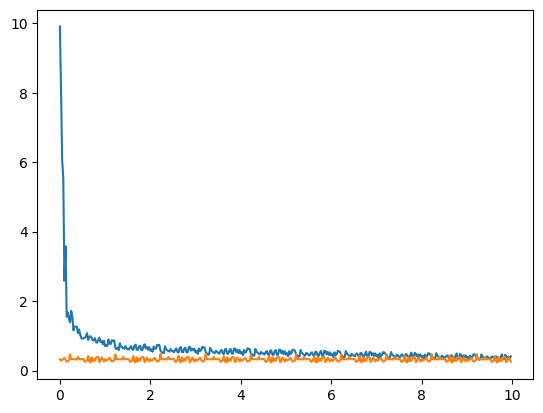

The staff was very nice and the food was great. --> the staff was not nice and the food was not good.
the food was mediocre at best , far too greasy and not cooked well --> the food was mediocre at best, far too greasy and not cooked well
she was not happy being there. --> she was happy to be there
she was happy being there. --> she was not happy being there.
the food 's ok , the service is among the worst i have encountered --> the food's ok, the service is among the worst i have encountered


In [89]:
#print training results
import matplotlib.pyplot as plt
import numpy as np
epochs = np.arange(0, len(results))/40.0
plt.plot(epochs,[x['loss'] for x in results])
plt.plot(epochs,[x['BLEU'] for x in results])
plt.show()

test_contexts = [
    "The staff was very nice and the food was great.",
    "the food was mediocre at best , far too greasy and not cooked well",
    "she was not happy being there.",
    "she was happy being there.",
    "the food 's ok , the service is among the worst i have encountered"
]
for context in test_contexts:
    input = tokenizer(context, return_tensors="pt")
    input = input.to('cuda')
    output = model.generate(input_ids=input['input_ids'], attention_mask=input['attention_mask'], max_length=100, num_beams=10, early_stopping=True)
    print(context,"-->",tokenizer.decode(output[0], skip_special_tokens=True))

In [85]:
#save hugingface model as t5_fine_tuned_parallel
model.save_pretrained('DualRLStyleTransfer/checkpoint/t5_fine_tuned_parallel')

In [86]:
#furhter training of the model with RL
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
#load model
model_t5 = T5ForConditionalGeneration.from_pretrained('DualRLStyleTransfer/checkpoint/t5_fine_tuned_parallel')
tokenizer_t5 = T5Tokenizer.from_pretrained("t5-small")
